  # Práctica 3:  Ejemplo de como calcular funciones empíricas ortogonales
  

## En este cuaderno vas a aprender
## 1. Como calcular las componentes principales para ver como la variabilidad se organiza
## 2. Como analizar los modos de variabilidad y reconstruir un campo

### Ejempl:  Africa Occidental
### Data: 100 años de ERA20

In [3]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import numpy.linalg as linalg
import time


## A continuación te indico las funciones a emplear.
Por un lado, una funcion para el cálculo de anomalías,
luego el cálculo de EOFs, que hace uso de anom y, finalmente la funcion IndexRegression para los mapas

In [ ]:
def anom(X,nyr,par):
#si par = st quiere decir que estandarizo. Si no, no (pongo, por ejemplo,'pp')
    ns,nt=np.shape(X) #una de las dimensiones es tiempo, la segunda, y la otra puede ser el numero de modos, o de espacios..
    nmes=int(nt/(nyr));
    
#dividimos el número de tiempos por el numero de años porque en caso de que queramos calcular
#anomalias estacionales de una secuencia mensual (enero-media(diciembre-enero-febrero)) en lugar de una media estacional

    An=ma.empty([ns,nt])

    for i in range(ns):
        A= X[i,:].reshape(nyr,nmes)
        mA=np.mean(A)
        for j in range(0,nyr):
            A[j,:]=A[j,:]-mA
        
        if  par=='st':
            
            stdA=ma.empty([nmes,])
            for k in range(nmes):
                stdA[k]=np.std(A[:,k])
                if stdA[k]!=0:
                    A[:,k]=A[:,k]/stdA[k]
    

#se reorganizan los datos
        A=np.transpose(A.reshape(nyr*nmes,1))
        An[i,:]=A;
              
    return An

In [4]:
def IndexRegression(Data,Index,alfa):
    [n1,n2]=Data.shape #los datos introducidos en Data tienen que tener dimesión n1=espacio, n2=tiempo 
    #inicializamos las matrices
    Cor=ma.empty([n1,])
    Pvalue=ma.empty([n1,])
    reg=ma.empty([n1,])
    reg_sig=ma.empty([n1,])
    for nn in range(n1): #para cada punto del espacio hacemos la correlación de Pearson
        bb=pearsonr(Data[nn,:],Index) #bb tiene dos salidas: la primera es corre y la segunda es p-value 
        Cor[nn]=bb[0]
        Pvalue[nn]=bb[1]
    #generamos una variable que es para que no se muestren mas que los valores de Cor cuando la correlacion
    #es significativa
    Cor_sig=ma.masked_where(Pvalue>alfa,Cor)
    #generamos el mapa de regresión mediante multiplicación matricial. Ojo con las dimensiones!!
    reg=Data.dot(Index)/ (n2-1)
    #igualmente, hacemos una máscara para que sólo se muestre el mapa de regresión cuando es significativo
    reg_sig=ma.masked_where(Pvalue>alfa,reg)
    return Cor,Pvalue,Cor_sig,reg,reg_siglla

In [6]:
def eof(y, nmes, nm, alfa):

        #Y es el campo
        #alfa es el nivel de significacion. Por ejemplo alfa=0.01 quiere decir un nivel de confianza del 99%\n",
        #nm es el numero de modos y nmes es simplemente si por cada año tenemos un dato medio (media de DEF) o el dato 
        # intraestacional (diciembre, enero y febrero por separado).Normalmente nmes es 1
        ny,nt=y.shape
        nyr=int(nt/nmes)
        #first you calculate the covariance matrix
        C=np.dot(y,np.transpose(y))
        R,d,R=linalg.svd(C,full_matrices=False)
        fvar=d/np.sum(d)
        fig,ax = plt.subplots(figsize = (10,5))
        plt.plot(fvar[:nm],color='Blue',Marker='o',label='Evolucion de autovalores')
        plt.legend()
        plt.grid()
        #Y había que transponerla si originariamente era (espacio, tiempo), pero ATN_e es (tiempo, espacio) así
        #que no se transpone
        PC=np.dot(np.transpose(y),R[:,:nm])
        #calculamos las anomalías estandarizadas
        #estandarizo la Pc
        PCs=anom(np.transpose(PC),nyr,'st')
        Cor=ma.empty([ny,nm]);pvalCor=ma.empty([ny,nm]);Cor_sig=ma.empty([ny,nm]);Reg=ma.empty([ny,nm]);Reg_sig=ma.empty([ny,nm])
        for i in range(nm):
            Cor[:,i], pvalCor[:,i], Cor_sig[:,i], Reg[:,i], Reg_sig[:,i]=IndexRegression(y,PCs[i,:],alfa)

        return Cor,Cor_sig,Reg,Reg_sig,PCs,fvar

##  Primero leemos los datos
### indica el path


In [7]:
path='/Users/ftaucm/Desktop/curso_UCAD/data/'
vari ='slp_ERA20_1900-2010.nc'
#vari='precip.mon.total.v401.nc'

###  Para leer correctamente un netcdf  puedes usar netCDF4 o puedes usar xarray. no obstante, te recomiendo que, si usas xarray, una vez calculadas las anomalias, pases los datos a una matriz usando np.array (A), siendo A la matriz a convertir.

In [8]:
fil = nc.Dataset(path + vari)
myvar = fil.variables
myvar

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (360,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (181,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:0.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: time
 current shape = (1332,)
 filling on, default _FillValue of -2147483647 used,
 'msl': <class 'netCDF4._netCDF4.Variable'>
 int16 msl(time, latitude, longitude)
     scale_factor: 0.14532849861901637
     add_offset: 100539.70858575069
     _FillValue: -32767
     missing_value: -32767
     units: Pa
     long_name: Mean sea level press

###check the dimensions of the variable. In your case, you can see how 'msl' are organized in (time, latitude, & longitude)


## Recuerda que este es el equema de las EOFs
1. elige una region
2. elige una estación del año
3. calcula anomalías usando anom
4. Calcula EOF (usando eof): 
    a. determiandno autovalores y autovectores de la matriz de covarianza, con linalg.svd
    b. haciendo la regression de los autovectores en los datos para, a continuación estandarizar la serie obtenida (anomalia estandarizada) y tener las Componentes Principales (PC)
    c. haciendo la regresión de la PC en los datos para obtener las EOFs como regresión (o correlación).

 # Step 1. Calcula anomalías
 1) Determina la región
 2) Determina la media temporal
 3) Determina las anomalías.


###  Antes de todo vamos a leer los datos y seleccionar la region

En nuestro caso vamos a tomar el Sahel

In [14]:
#lon = fil.variables['lon'][:]
#lat = fil.variables['lat'][:]
#SLP = fil.variables['precip'][:]
lon = fil.variables['longitude'][:]
lat = fil.variables['latitude'][:]
SLP = fil.variables['msl'][:]

nt, nlat, nlon = SLP.shape
nm = 12
nyears = int(nt/nm)
ATN=np.roll(SLP,180, axis=2)
lon2=lon-180
lonmin,lonmax,latmin,latmax = -40, 20, 0, 20
ATN = SLP[:,:,(lon2>lonmin)&(lon2<lonmax)][:,(lat>latmin)&(lat<latmax),:]
yrs = np.arange(1900,2011)
lon_ATN= lon2[(lon2>lonmin)&(lon2<lonmax)]
lat_ATN=lat[(lat>latmin)&(lat<latmax)]

<ipython-input-14-6df86efce991>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = fil.variables['longitude'][:]
<ipython-input-14-6df86efce991>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = fil.variables['latitude'][:]
<ipython-input-14-6df86efce991>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To sil

In [15]:
t, nlon2, nlat2= ATN.shape


In [16]:
ATN_e=ATN.reshape(nyears,nm,nlat2*nlon2)[:,[6,7,8],:].mean(1) #ponemos los datos como si fueran


In [17]:
ATN_e.shape

(111, 1121)

## calculamos anomalías


In [18]:
#años, meses, espacio y sólo promediamos el mes 0 que es enero
ATN_as = anom(np.transpose(ATN_e),nyears,'pp')

# es importante ir chequeando las dimensiones para ver que todo va bien

In [19]:
ATN_as.shape

(1121, 111)

Text(0.5, 1.0, 'SLP january 1996 hPa')

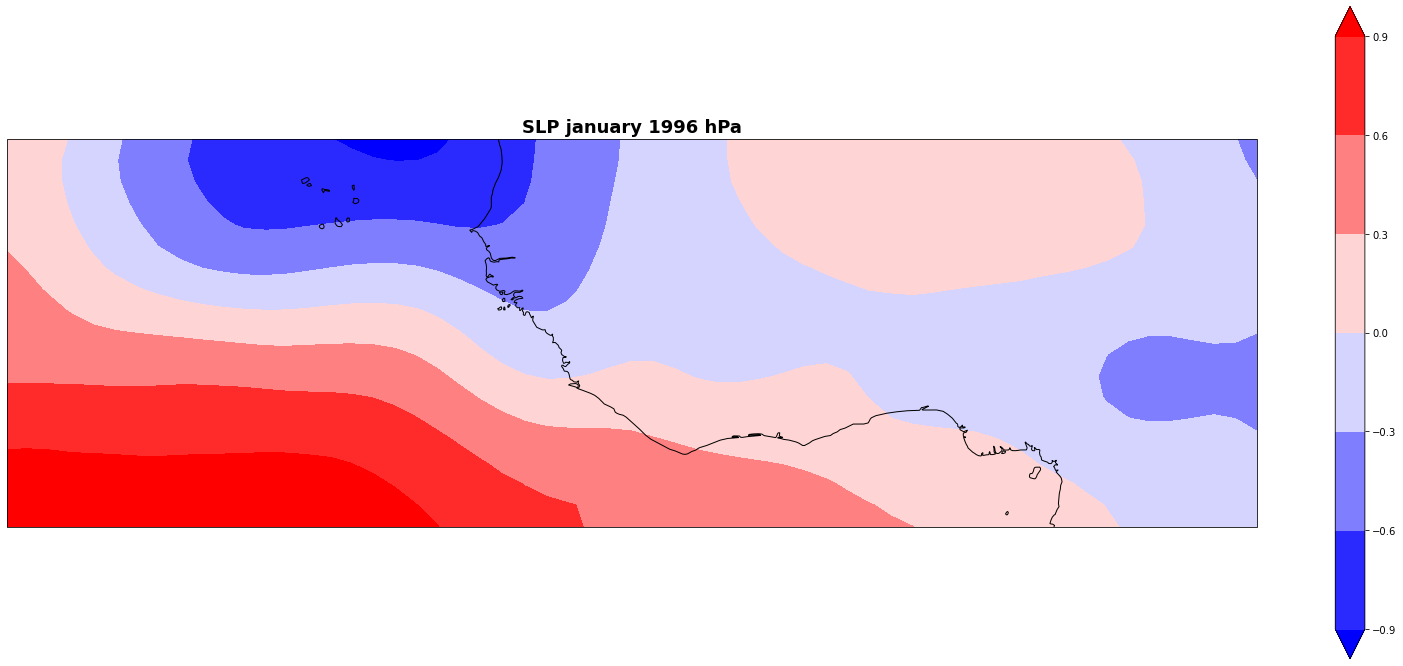

In [20]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_ATN,lat_ATN,ATN_as[:,97].reshape(len(lat_ATN),len(lon_ATN))/100,cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SLP january 1996 hPa',fontsize=18,weight='bold')


In [21]:
y=ATN_as
nmes=1
nm=3
alfa=0.01

### Ahora diagonalizamos la matriz y sacamos los mapas todo ellos empleando la funcion eig

# Step 3: Aplicar EOF

<ipython-input-6-4655c77ba227>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(fvar[:nm],color='Blue',Marker='o',label='Evolucion de autovalores')


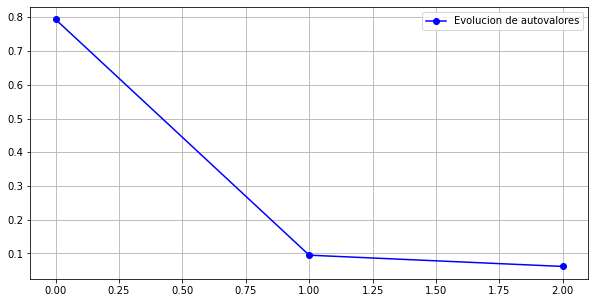

In [22]:
 Cor,Cor_sig,Reg,Reg_sig,PCs,fvar = eof(y, nmes, nm, alfa)

## Es importante ver como evolucionan los autovalores (fracción de varianza)

### Elige el modo que quieres analizar

In [23]:
modo =1 #modo 2 por ejemplo
PC1s=PCs[modo,:]
PC1s.shape

(111,)

In [24]:
a=range(1901,2011)

In [25]:
a=np.arange(1901,2011)

In [26]:
PC1s.shape

(111,)

In [27]:
fvar[modo]

0.09496428075741559

TypeError: can only concatenate str (not "numpy.float64") to str

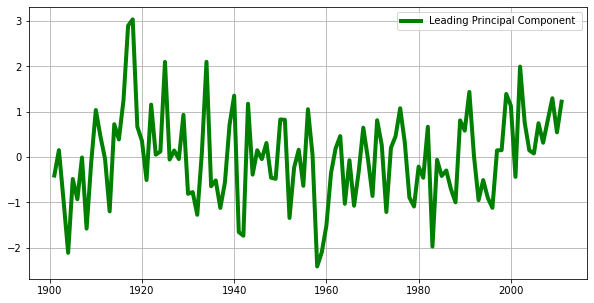

In [44]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(np.arange(1901,2012),(PCs[1,:]),linewidth= 4,color='green',label='Leading Principal Component ')
ax.grid()
ax.legend()
ax.set_title('Leading  principal component fvar='+fvar[modo],fontsize=18,weight='bold')


In [45]:
Reg.shape

(1121, 3)

Se puede ver cierta tendencia y algo de variabilidad decadal, pero vamos a dejarlo así por ahora 

Text(0.5, 1.0, 'EOF regresion map ')

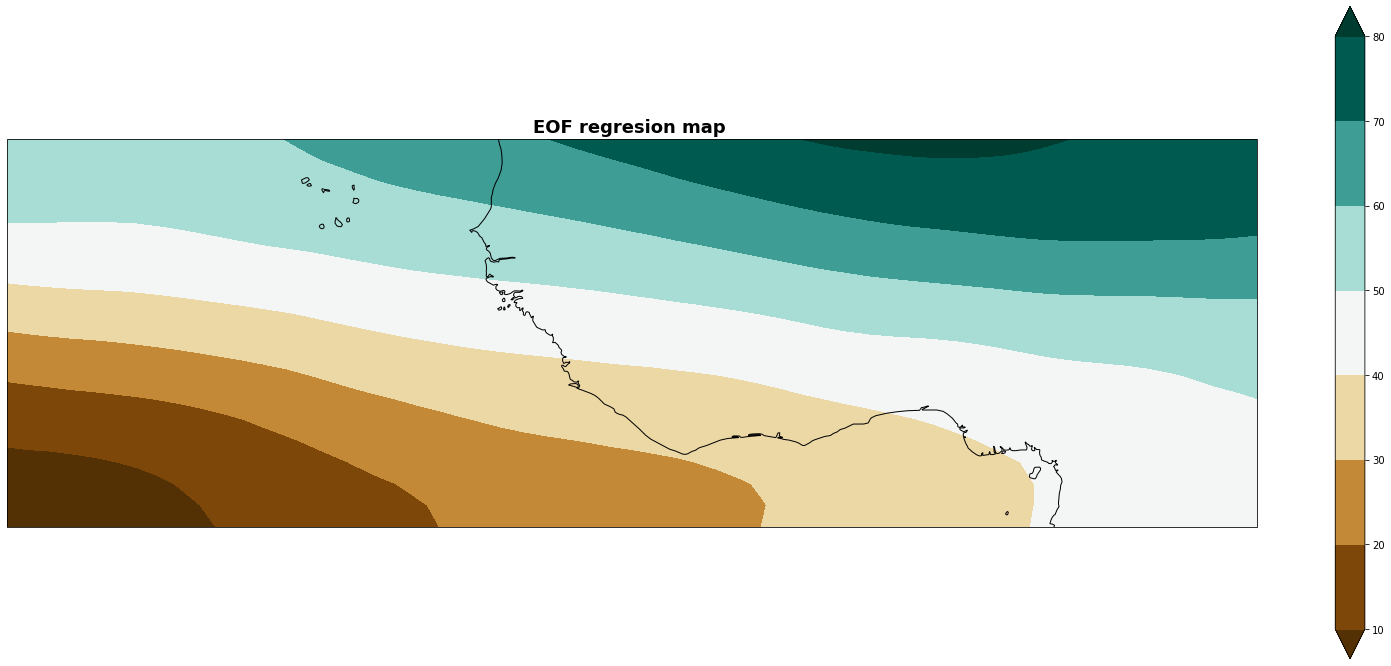

In [31]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_ATN,lat_ATN,Reg[:,0].reshape(len(lat_ATN),len(lon_ATN)),cmap='BrBG',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('EOF regresion map ',fontsize=18,weight='bold')


#### A veces es necesario quitar la tendencia, cosa que se hace quitando el ajuste lineal (regresion lineal)

### También es interesante distinguir entre alta y baja variabilidad

In [32]:
PC1sd=signal.detrend(PC1s)

In [33]:
nyc=12
n=10
Wn=1/6
b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
low = signal.filtfilt(b,a,PC1sd)

b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(b,a,PC1sd)

In [50]:
mode=1

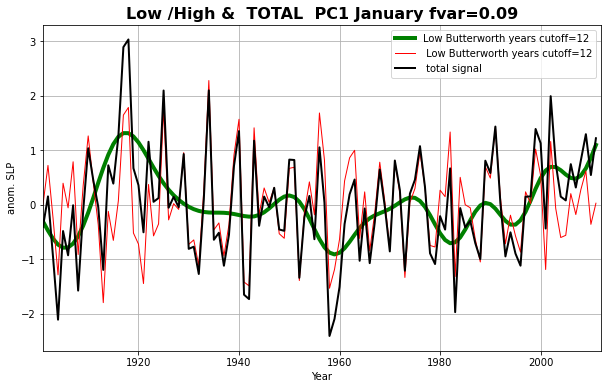

In [51]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Low /High &  TOTAL  PC1 January fvar='+'%.2f'%fvar[mode],fontsize=16,weight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('anom. SLP')
ax.plot(range(1901,2012),low,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1901,2012),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(range(1901,2012),PC1s,linewidth= 2,color='black',label=' total signal')
ax.set_xlim([1901,2012])
ax.legend()
ax.grid()

# Reconstrucción del campo

Hemos visto cómo, conociendo los componentes podemos reconstruir la variabilidad siguiendo esta expresión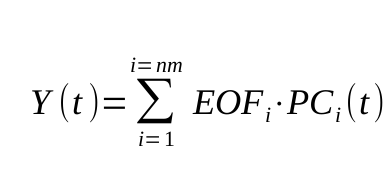

### Reconstrucción de  ATN_e en enero de  1996


In [30]:
yrs

array([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010])

In [31]:
y.shape

(1121, 111)

In [35]:
Y=y[:,yrs==2010]


Text(0.5, 1.0, 'SLP 1997')

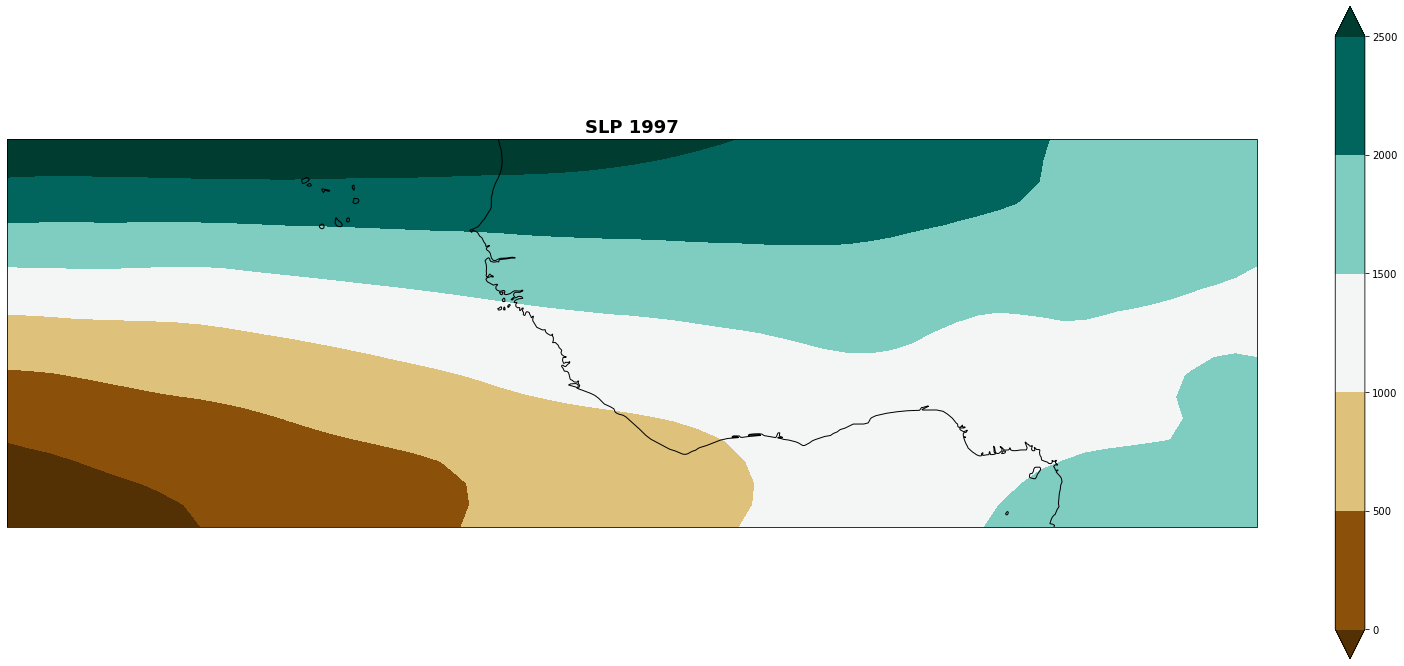

In [38]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
#im = ax.contourf(lon_ATN,lat_ATN,Y.reshape(len(lat_ATN),len(lon_ATN))/100,levels=np.arange(-,1.1,0.1),cmap='BrBG',extend='both'
              # ,transform = ccrs.PlateCarree())
im = ax.contourf(lon_ATN,lat_ATN,Y.reshape(len(lat_ATN),len(lon_ATN))*10,cmap='BrBG',extend='both'
               ,transform = ccrs.PlateCarree())

ax.coastlines()
cbar=fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SLP 1997',fontsize=18,weight='bold')

## Reconstrucción con un modo

In [39]:
Reg.shape

(1121, 3)

In [40]:
Yreconst=Reg[:,0]*PCs[0,yrs==2010]

In [41]:
Yreconst.shape

(1121,)

### Dibujamos el campo reconstruido

Text(0.5, 1.0, 'SLP 1996 reconstruida con PC1')

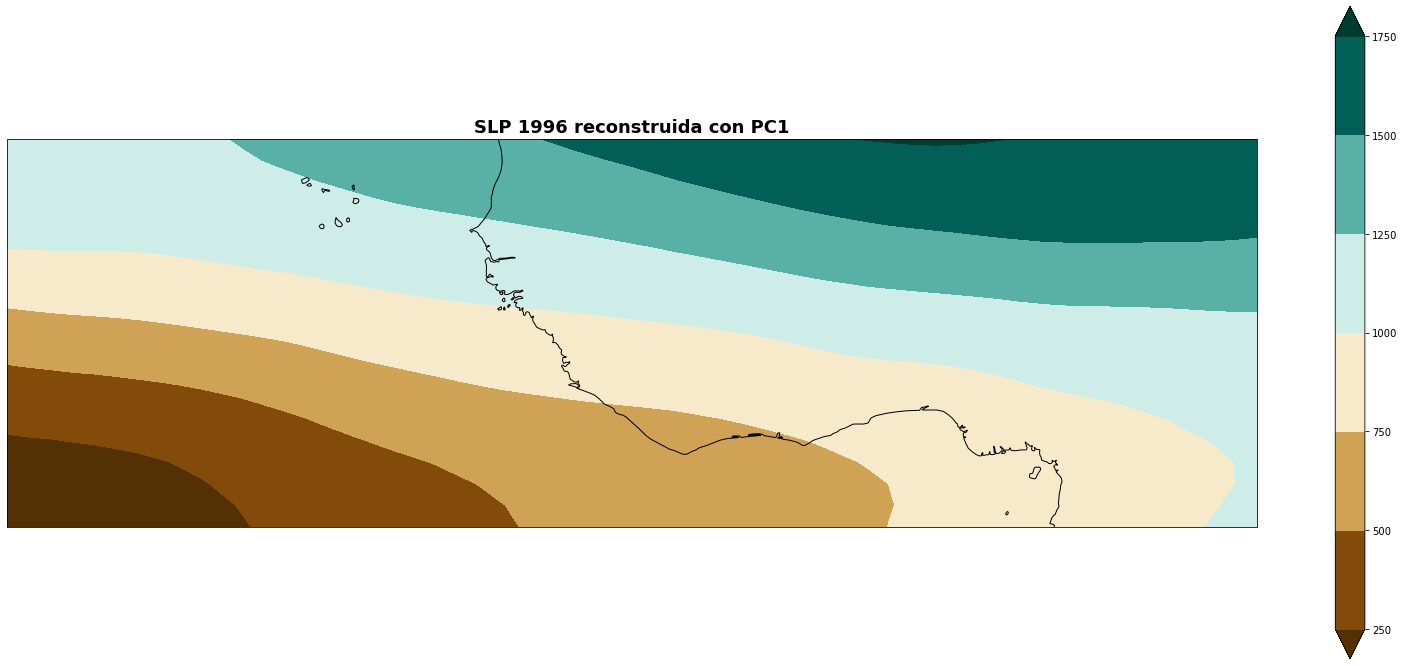

In [43]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
#im = ax.contourf(lon_ATN,lat_ATN,Yreconst.reshape(len(lat_ATN),len(lon_ATN))/100,cmap='BrBG',extend='both'
#               ,transform = ccrs.PlateCarree())
im = ax.contourf(lon_ATN,lat_ATN,Yreconst.reshape(len(lat_ATN),len(lon_ATN))*10,cmap='BrBG',extend='both'
               ,transform = ccrs.PlateCarree())


ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SLP 1996 reconstruida con PC1',fontsize=18,weight='bold')